In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import norm
import scipy.stats as st

import warnings

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params); np.random.seed(0)
style.use('tableau-colorblind10')

#%matplotlib inline
tqdm.pandas()
warnings.filterwarnings('ignore')

# import plotly
# import plotly.figure_factory as ff
# import plotly.graph_objs as go 
# import plotly.express as px
# import plotly.offline as pyo
# from plotly.subplots import make_subplots
#pyo.init_notebook_mode()

Note that the `Load & Pre-process Datasets` are the replicate of `main.ipynb`.

# Load & Pre-process Datasets

This procedures are the replicates in the pre-processing procedures in `main.ipynb`.

## 1. Load `food` dataset

- It contains all 37.1M pairs of food pantry info and its BGs within 25 miles. We have shown this dataset from the jupyter file `prepare_data_statistics.ipynb`. 
- There are 34,475 food pantries and banks (FPs) in the dataset. 

In [2]:
food = pd.read_pickle('../data/fp_bg_pairs.pkl')

In [3]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37154567 entries, 0 to 37154566
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   address      object 
 1   ad_lat       float64
 2   ad_lon       float64
 3   ad_bg_fips   object 
 4   bg_fips      object 
 5   bg_lat       float64
 6   bg_lon       float64
 7   distance_mi  float64
dtypes: float64(5), object(3)
memory usage: 2.2+ GB


In [4]:
food.address.nunique()

34475

## 2. Load `bg` dataset 
- the original 2020 ADI dataset from UW Madison's Neighborhood Atlas).

- `bg_cont`: ADI dataset of BGs in the continental U.S -> a total of 239,780 BGs in 50 states and the DC.

In [5]:
bg = pd.read_csv('../data/US_2020_ADI_Census Block Group_v3.2.csv',
                dtype={'FIPS':str, 'ADI_NATRANK':str, 'ADI_STATERNK':str})
bg = bg[['FIPS', 'ADI_NATRANK', 'ADI_STATERNK']]
bg = bg.rename(columns={'FIPS':'bg_fips'})

In [6]:
bg_cont = bg.loc[(~bg.bg_fips.str.startswith('72')) 
             & (~bg.bg_fips.str.startswith('78'))
            & (~bg.bg_fips.str.startswith('69'))
            & (~bg.bg_fips.str.startswith('66'))
            & (~bg.bg_fips.str.startswith('60'))]

In [7]:
bg_cont.bg_fips.nunique()

239780

## 3. Find and merge the state/county info for each BG

- `find_sate_fips` retrieves the corresponding state information based on the first two digits of each BG's FIPS. 
- `us-state-fips.csv` contains all FIPS code of the 50 states and DC in the continental U.S.
- Note that the first two and five digits of each BG's FIPS indicate the BG's state and county, respectively. 

In [8]:
def find_state_fips(bg, state_data):
    
    st_fips = bg[:2]
    for i in range(len(state_data)):
        if state_data['st_fips'][i] == st_fips:            
            return state_data['st_abb'][i]

In [9]:
state_fips = pd.read_csv('../data/us-state-fips.csv',
                        dtype = {'stname':str, ' st':str, ' stusps':str})
state_fips = state_fips.rename(columns={'stname':'STATE', ' st':'st_fips', ' stusps':'st_abb'})
state_fips.st_abb = state_fips.st_abb.str.strip()
state_fips.st_fips = state_fips.st_fips.str.strip()

In [10]:
bg_cont['bg_state'] = bg_cont.progress_apply(lambda x:find_state_fips(x.bg_fips, state_fips), axis=1)
bg_cont['bg_county']  = bg_cont.progress_apply(lambda x:x.bg_fips[0:5], axis=1)

100%|██████████| 239780/239780 [00:00<00:00, 271683.82it/s]


## 4. Find each BG's rural status (based on RUCC 2013 Codes)
- `county_rurality`: the entire county-level dataset of RUCC 2013 codes from USDA ERS, where BGs in counties tagged with all subcategories within 'Metro' are considered as urban and all within 'Nonmetro' as rural. 

In [11]:
county_rurality = pd.read_csv('../data/ruralurbancodes2013.csv', 
                          dtype = {'FIPS':str})

county_rurality['RUCC_2013'] = county_rurality['RUCC_2013'].astype(str)
county_rurality.Description = county_rurality.Description.str.strip()

def decide_urban_degree(text):
    
    if text in ['Metro - Counties in metro areas of 250,000 to 1 million population',
       'Metro - Counties in metro areas of fewer than 250,000 population', 
               'Metro - Counties in metro areas of 1 million population or more']:
        
        return 'Metro'
    
    elif text in ['Nonmetro - Urban population of 20,000 or more, adjacent to a metro area', 
                  'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area']:
        return 'Nonmetro'
    
    elif text in ['Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area',
                  'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area']:
        return 'Nonmetro'
    
    elif text in ['Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area',
                  'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area']:
        return 'Nonmetro'
    else:
        return 'N/A'


county_rurality['status'] = county_rurality.apply(lambda x:decide_urban_degree(x.Description), axis=1)
county_rurality = county_rurality.rename(columns={'FIPS':'bg_county'})
county_rurality 

,bg_county,State,County_Name,Population_2010,RUCC_2013,Description,status
0,01001,AL,Autauga County,"54,571",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
1,01003,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...,Metro
2,01005,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro
3,01007,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...,Metro
4,01009,AL,Blount County,"57,322",1.0,Metro - Counties in metro areas of 1 million p...,Metro
...,...,...,...,...,...,...,...
3229,72151,PR,Yabucoa Municipio,"37,941",1.0,Metro - Counties in metro areas of 1 million p...,Metro
3230,72153,PR,Yauco Municipio,"42,043",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
3231,78010,VI,St. Croix Island,"50,601",5.0,"Nonmetro - Urban population of 20,000 or more,...",Nonmetro
3232,78020,VI,St. John Island,"4,170",7.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro


## 5. Merge `bg_cont` with the `county_rurality` information

- Results in a dataset of all block groups' FIPS code, their ADI, state/county, and urban/rural status. 

In [12]:
bg_cont = bg_cont.merge(county_rurality[['bg_county', 'status']].drop_duplicates(subset=['bg_county']), how='left', on='bg_county')

In [13]:
bg_cont

,bg_fips,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,73,5,AL,01001,Metro
1,010010201002,62,3,AL,01001,Metro
2,010010202001,83,7,AL,01001,Metro
3,010010202002,87,7,AL,01001,Metro
4,010010203001,73,5,AL,01001,Metro
...,...,...,...,...,...,...
239775,560459511001,65,8,WY,56045,Nonmetro
239776,560459511002,49,6,WY,56045,Nonmetro
239777,560459513001,85,10,WY,56045,Nonmetro
239778,560459513002,70,9,WY,56045,Nonmetro


All BGs in our dataset  `food` that are identified as having at least a FP < 25 miles 

- 238,536 BGs: have FPs ≤ 25 miles
- 1,244 BGs: have no FPs ≤ 25 miles

In [14]:
bg_with_fp = food.bg_fips.unique()
len(bg_with_fp)

238536

Now, it's time to pre-process the accessibility dataset. 

## 7. Pre-process the accessibility dataset

`bg_access`: the dataset that we created from `compute_travel_time.ipynb` file, which consists of all information about each BG and its nearest FP, along with distance/travel time between them, ADI and state info. 

In [15]:
bg_access = pd.read_csv('../data/bg_pantry_travel_time_updated.csv', dtype={'bg_fips':str})

In [17]:
bg_access.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238536 entries, 0 to 238535
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bg_fips       238536 non-null  object 
 1   address       238536 non-null  object 
 2   distance_mi   238536 non-null  float64
 3   transit_time  166589 non-null  float64
 4   walking_time  237842 non-null  float64
dtypes: float64(3), object(2)
memory usage: 9.1+ MB


Merge the accessibility dataset with `bg_cont` that contains each BG's ADI, state/county, and rurality information 

In [18]:
bg_access = bg_access.merge(bg_cont.drop_duplicates(subset=['bg_fips']), how='left', on='bg_fips')

In [19]:
bg_access

,bg_fips,address,distance_mi,transit_time,walking_time,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,20.08,20.08,73,5,AL,01001,Metro
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,37.30,37.30,62,3,AL,01001,Metro
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,20.33,20.33,83,7,AL,01001,Metro
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,8.40,8.40,87,7,AL,01001,Metro
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,42.63,42.63,73,5,AL,01001,Metro
...,...,...,...,...,...,...,...,...,...,...
238531,560430003012,"620 Big Horn Ave, Worland, WY 82401",0.529835,14.47,14.47,76,10,WY,56043,Nonmetro
238532,560430003013,"620 Big Horn Ave, Worland, WY 82401",0.308140,7.37,7.37,68,9,WY,56043,Nonmetro
238533,560430003021,"620 Big Horn Ave, Worland, WY 82401",0.966369,27.67,27.67,62,8,WY,56043,Nonmetro
238534,560430003022,"620 Big Horn Ave, Worland, WY 82401",1.192660,29.00,29.00,58,7,WY,56043,Nonmetro


Because `bg_access` contains only 238,536 BGs that do have at least one FP ≤ 25 miles so that we can compute travel time, for the entire analysis, we update `bg_access` by also including the other BGs that do not have FPs ≤ 25 miles.

In [20]:
bg_access = pd.concat([bg_access, bg_cont.loc[(~bg_cont.bg_fips.isin(bg_with_fp))]])

In [22]:
bg_access

,bg_fips,address,distance_mi,transit_time,walking_time,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,20.08,20.08,73,5,AL,01001,Metro
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,37.30,37.30,62,3,AL,01001,Metro
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,20.33,20.33,83,7,AL,01001,Metro
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,8.40,8.40,87,7,AL,01001,Metro
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,42.63,42.63,73,5,AL,01001,Metro
...,...,...,...,...,...,...,...,...,...,...
239768,560430002003,NaN,NaN,NaN,NaN,47,5,WY,56043,Nonmetro
239776,560459511002,NaN,NaN,NaN,NaN,49,6,WY,56045,Nonmetro
239777,560459513001,NaN,NaN,NaN,NaN,85,10,WY,56045,Nonmetro
239778,560459513002,NaN,NaN,NaN,NaN,70,9,WY,56045,Nonmetro


Based on our definition of accessibility, we compute shorter travel time to measure accessibility, by the least travel time by transit or walking. This is stored in the `access` column. 

In [23]:
def shorter_travel(transit, walk):
    travel = 0
    if np.isnan(transit) == False:
        if np.isnan(walk) == False:
            if transit >= walk: # transit 0 walk 0
                travel = walk
            else:
                travel = transit
        else: # transit 0 walk x
            travel = transit
    else: #transit x
        if np.isnan(walk) == False: # transit x walk 0
            travel = walk
        else:
            travel = None # transit x walk x

    return travel

In [24]:
bg_access['access'] = bg_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 239780/239780 [00:01<00:00, 126090.30it/s]


In [25]:
def isnumber(x): # convert all ADI to its numeric format
    try:
        d = int(x)
        return d
    except:
        return None


bg_access['ADI_NATRANK'] = bg_access.progress_apply(lambda x:isnumber(x.ADI_NATRANK), axis=1)

100%|██████████| 239780/239780 [00:00<00:00, 253029.80it/s]


Then, we have all 239,780 BGs in the continental U.S., along with their accessibility information!

**Divide into three accessibility groups of BGs**

In [26]:
easy_access = pd.concat([bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time <= 20)], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time.isna())], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time <= 20)], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time > 20)], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time <= 20)]], ignore_index=True)

easy_access['access'] = easy_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 129064/129064 [00:01<00:00, 126822.78it/s]


In [27]:
diff_access = pd.concat([bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time > 20)], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time.isna())], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time > 20)]], ignore_index=True)

diff_access['access'] = diff_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 108870/108870 [00:00<00:00, 126592.41it/s]


In [28]:
no_access = bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time.isna())]
no_access['access'] = no_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 1846/1846 [00:00<00:00, 90362.20it/s]


-------------------------------------------------------------------------------------------

# Supplementary Table 1

- Number of food pantries and banks (FPs) by states (including the District of Columbia (DC))

In [35]:
fp_address = pd.DataFrame(food.groupby('address').first())

In [36]:
fp_address

,ad_lat,ad_lon,ad_bg_fips,bg_fips,bg_lat,bg_lon,distance_mi
address,,,,,,,
"06 Manzano Lane Los Lunas, NM 87031",34.801174,-106.549210,350619701012,350010001071,35.125459,-106.485106,22.682252
"1 2nd Ave SE, Kulm, ND 58456",46.302290,-98.945950,380459722001,380219733002,46.103638,-98.771834,16.042335
"1 Angell Rd Cumberland, RI 02864",41.937607,-71.429375,440070113013,090159001004,41.962082,-71.819513,20.105113
"1 Angwin Ave Angwin, CA 94508",38.570354,-122.442760,060552017003,060330011022,38.837973,-122.731706,24.162348
"1 Angwin Ave, Angwin, CA 94508",38.570354,-122.442760,060552017003,060330011022,38.837973,-122.731706,24.162348
...,...,...,...,...,...,...,...
"S81 W19150, Apollo Dr, Muskego, WI 53150",42.896397,-88.152695,551332017043,550551008003,42.997751,-88.592276,23.292471
"W New York Ave and Eastman Rd Southern Pines, NC 28387",35.190487,-79.408745,371259508013,370370205003,35.551039,-79.419569,24.901859
"W Vineyard St and N Church St Wailuku, HI 96793",20.888884,-156.503600,150090309012,150090302011,20.861091,-156.246030,16.727099


In [37]:
fp_address['address_state'] = fp_address.progress_apply(lambda x:find_state_fips(x.ad_bg_fips, state_fips), axis=1)

100%|██████████| 34475/34475 [00:02<00:00, 17155.33it/s]


In [38]:
fp_address

,ad_lat,ad_lon,ad_bg_fips,bg_fips,bg_lat,bg_lon,distance_mi,address_state
address,,,,,,,,
"06 Manzano Lane Los Lunas, NM 87031",34.801174,-106.549210,350619701012,350010001071,35.125459,-106.485106,22.682252,NM
"1 2nd Ave SE, Kulm, ND 58456",46.302290,-98.945950,380459722001,380219733002,46.103638,-98.771834,16.042335,ND
"1 Angell Rd Cumberland, RI 02864",41.937607,-71.429375,440070113013,090159001004,41.962082,-71.819513,20.105113,RI
"1 Angwin Ave Angwin, CA 94508",38.570354,-122.442760,060552017003,060330011022,38.837973,-122.731706,24.162348,CA
"1 Angwin Ave, Angwin, CA 94508",38.570354,-122.442760,060552017003,060330011022,38.837973,-122.731706,24.162348,CA
...,...,...,...,...,...,...,...,...
"S81 W19150, Apollo Dr, Muskego, WI 53150",42.896397,-88.152695,551332017043,550551008003,42.997751,-88.592276,23.292471,WI
"W New York Ave and Eastman Rd Southern Pines, NC 28387",35.190487,-79.408745,371259508013,370370205003,35.551039,-79.419569,24.901859,NC
"W Vineyard St and N Church St Wailuku, HI 96793",20.888884,-156.503600,150090309012,150090302011,20.861091,-156.246030,16.727099,HI


In [39]:
num_fps_state = pd.DataFrame(fp_address.address_state.value_counts()).sort_index()

In [40]:
num_fps_state.head()

,count
address_state,
AK,146
AL,843
AR,970
AZ,660
CA,1583


- Number of BGs per state

In [41]:
num_bg_state = pd.DataFrame(bg_access.bg_state.value_counts()).sort_index()

- Number of easy/difficult/no access BGs per state

In [42]:
num_easy_state = pd.DataFrame(easy_access.bg_state.value_counts()).sort_index()
num_diff_state = pd.DataFrame(diff_access.bg_state.value_counts()).sort_index()
num_no_state = pd.DataFrame(no_access.bg_state.value_counts()).sort_index()

In [43]:
per_easy_state = pd.DataFrame(num_easy_state*100/num_bg_state).round(1)
per_diff_state = pd.DataFrame(num_diff_state*100/num_bg_state).round(1)
per_no_state = pd.DataFrame(num_no_state*100/num_bg_state).round(1)

In [44]:
supp_t_1 = pd.concat([num_fps_state, num_bg_state, num_easy_state, num_diff_state, num_no_state, per_easy_state, per_diff_state, per_no_state], axis=1)
supp_t_1.columns = ['num_fp', 'num_bg', 'num_easy_bg', 'num_diff_bg', 'num_no_bg', 'perc_easy_bg', 'perc_diff_bg', 'perc_no_bg']

In [45]:
supp_t_1

,num_fp,num_bg,num_easy_bg,num_diff_bg,num_no_bg,perc_easy_bg,perc_diff_bg,perc_no_bg
AK,146,504,218,183,103.0,43.3,36.3,20.4
AL,843,3925,1383,2517,25.0,35.2,64.1,0.6
AR,970,2294,908,1386,NaN,39.6,60.4,NaN
AZ,660,4773,2559,2101,113.0,53.6,44.0,2.4
CA,1583,25607,16049,9368,190.0,62.7,36.6,0.7
CO,557,4058,2372,1639,47.0,58.5,40.4,1.2
CT,554,2716,1711,1001,4.0,63.0,36.9,0.1
DC,41,571,546,25,NaN,95.6,4.4,NaN
DE,85,706,375,330,1.0,53.1,46.7,0.1
FL,1504,13388,7228,6075,85.0,54.0,45.4,0.6


In [64]:
per_easy_state.sort_values(by='count', ascending=False).head(5)


,count
bg_state,
DC,95.6
RI,76.5
NY,73.5
NJ,71.3
MA,71.3


# Supplementary Table 2

Refer to `regression.ipynb` file. 

# Supplementary Figure 1

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0'),
  Text(6, 0, '7.0'),
  Text(7, 0, '8.0'),
  Text(8, 0, '9.0'),
  Text(9, 0, '10.0'),
  Text(10, 0, '11.0'),
  Text(11, 0, '12.0'),
  Text(12, 0, '13.0'),
  Text(13, 0, '14.0'),
  Text(14, 0, '15.0'),
  Text(15, 0, '16.0'),
  Text(16, 0, '17.0'),
  Text(17, 0, '18.0'),
  Text(18, 0, '19.0'),
  Text(19, 0, '20.0'),
  Text(20, 0, '21.0'),
  Text(21, 0, '22.0'),
  Text(22, 0, '23.0'),
  Text(23, 0, '24.0'),
  Text(24, 0, '25.0')])

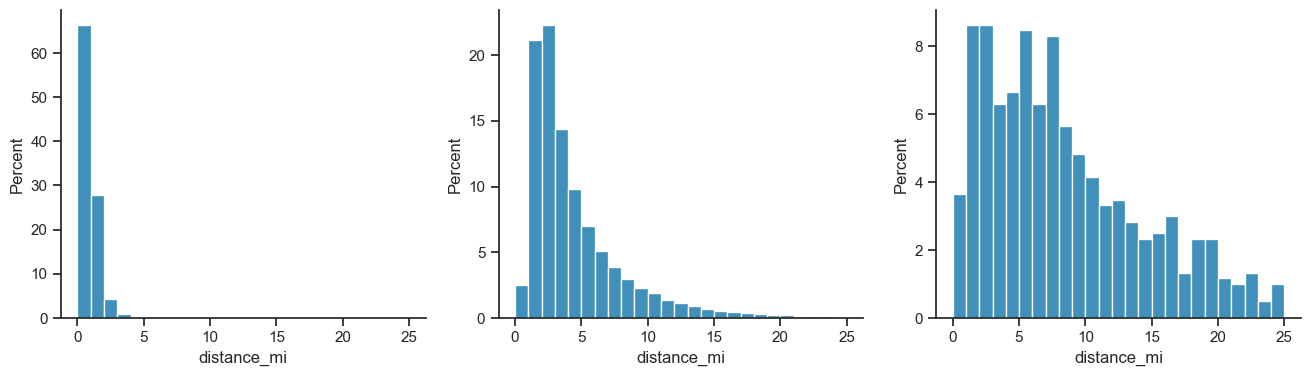

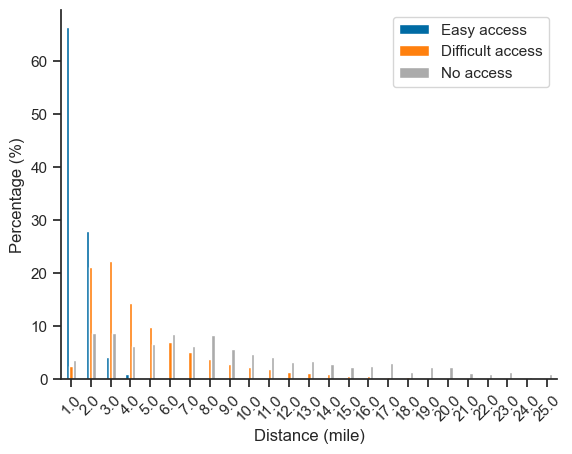

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
fig.subplots_adjust(hspace = 0.5)
#fig.suptitle('Distribution of Geographic Accessibility from BGs to each of their nearest FPs')

# distance
e = sns.histplot(ax=axes[0], data=easy_access.distance_mi, stat='percent', 
            bins=np.arange(0, 25.1, 1))
#axes[0].set(xlabel='distance (mi)', ylabel='Percentage (%)')
#axes[0].set_title('Easy access by transit or walk', pad=5)

d = sns.histplot(ax=axes[1], data=diff_access.distance_mi, stat='percent', 
            bins=np.arange(0, 25.1, 1))
#axes[1].set(xlabel='distance (mi)', ylabel='Percentage (%)')
#axes[1].set_title('Difficult access by transit or walk')


n = sns.histplot(ax=axes[2], data=no_access.distance_mi, stat='percent', 
            bins=np.arange(0, 25.1, 1))
#axes[2].set(xlabel='distance (mi)', ylabel='Percentage (%)')
#axes[2].set_title('No accessible by either transit or walk')


# Get heights of each bin
e_heights = [h.get_height() for h in e.patches]
d_heights = [h.get_height() for h in d.patches]
n_heights = [h.get_height() for h in n.patches]

bins = np.arange(1, 25.1, 1)

pd.DataFrame({'Easy access':e_heights, 
              'Difficult access':d_heights,
              'No access': n_heights}, index=bins).plot.bar(rot=0)
plt.xlabel('Distance (mile)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Supplementary Figure 2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '0'),
  Text(1, 0, '10'),
  Text(2, 0, '20'),
  Text(3, 0, '30'),
  Text(4, 0, '40'),
  Text(5, 0, '50'),
  Text(6, 0, '60'),
  Text(7, 0, '70'),
  Text(8, 0, '80'),
  Text(9, 0, '90'),
  Text(10, 0, '100'),
  Text(11, 0, '110'),
  Text(12, 0, '120'),
  Text(13, 0, '130'),
  Text(14, 0, '140'),
  Text(15, 0, '150'),
  Text(16, 0, '160'),
  Text(17, 0, '170'),
  Text(18, 0, '180'),
  Text(19, 0, '190')])

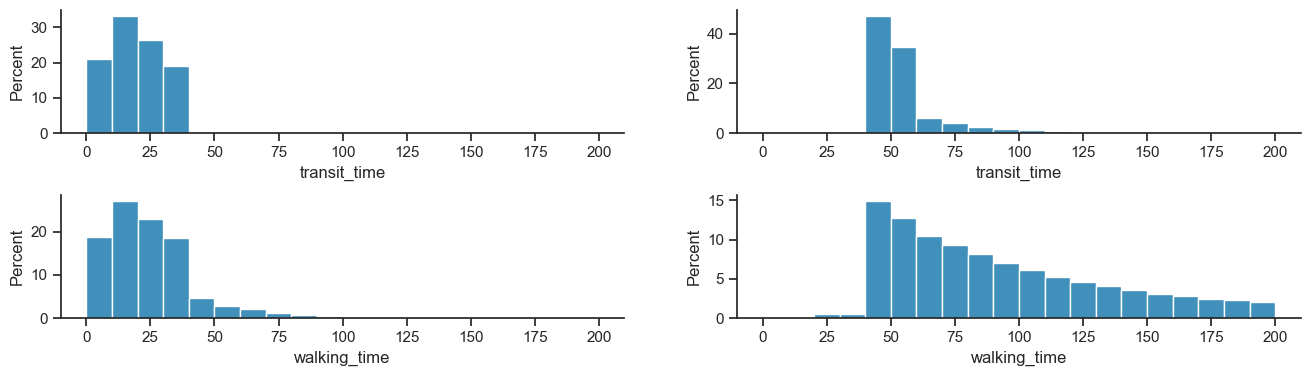

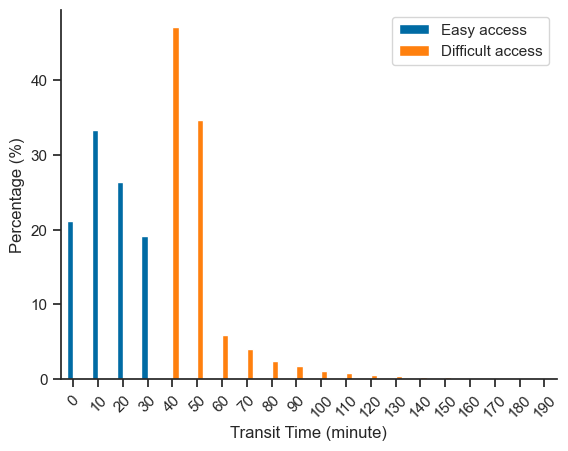

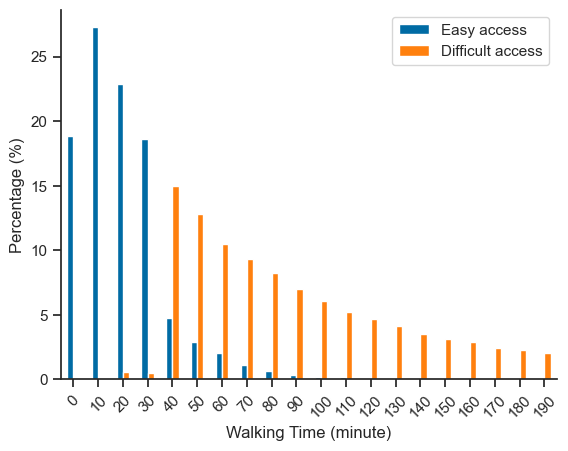

In [51]:
# Public Transit & Walking

fig, axes = plt.subplots(2, 2, figsize=(16,4))
fig.subplots_adjust(hspace = 0.5)

e_t = sns.histplot(ax=axes[0, 0], data=easy_access.transit_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[0,0].set(xlabel='Travel time by public transit (min)')

d_t = sns.histplot(ax=axes[0, 1], data=diff_access.transit_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[1,0].set(xlabel='Travel time by public transit (min)', ylabel='Density')

e_w = sns.histplot(ax=axes[1, 0], data=easy_access.walking_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[0,1].set(xlabel='Travel time by walking (min)', ylabel='Density')

d_w = sns.histplot(ax=axes[1, 1], data=diff_access.walking_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[1,1].set(xlabel='Travel time by walking (min)', ylabel='Density')


# Get heights of each bin
e_t_heights = [h.get_height() for h in e_t.patches]
d_t_heights = [h.get_height() for h in d_t.patches]

e_w_heights = [h.get_height() for h in e_w.patches]
d_w_heights = [h.get_height() for h in d_w.patches]

bins = np.arange(0, 200, 10)

pd.DataFrame({'Easy access':e_t_heights, 
              'Difficult access':d_t_heights}, index=bins).plot.bar(rot=0)
plt.xlabel('Transit Time (minute)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)


pd.DataFrame({'Easy access':e_w_heights, 
              'Difficult access':d_w_heights}, index=bins).plot.bar(rot=0)
plt.xlabel('Walking Time (minute)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Supplementary Figure 3

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '[1-10]'),
  Text(1, 0, '[11-20]'),
  Text(2, 0, '[21-30]'),
  Text(3, 0, '[31-40]'),
  Text(4, 0, '[41-50]'),
  Text(5, 0, '[51-60]'),
  Text(6, 0, '[61-70]'),
  Text(7, 0, '[71-80]'),
  Text(8, 0, '[81-90]'),
  Text(9, 0, '[91-100]')])

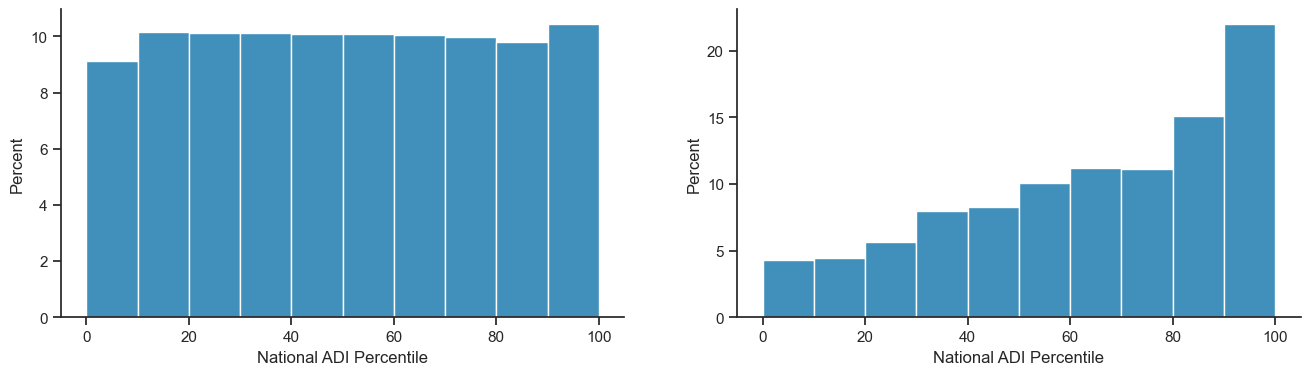

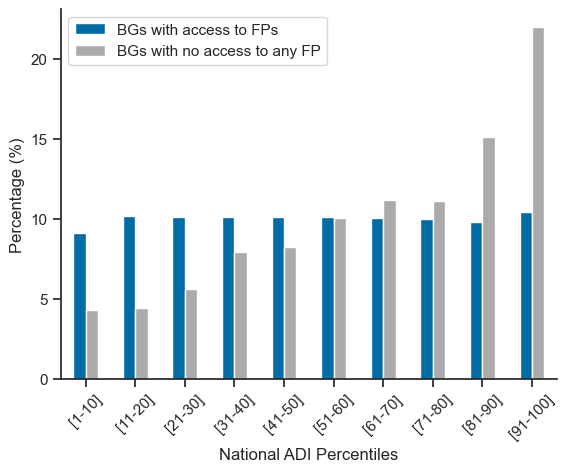

In [52]:
fig, axes = plt.subplots(1, 2,  figsize=(16, 4))
fig.subplots_adjust(hspace = 0.4)
#fig.tight_layout()

y = sns.histplot(ax=axes[0], data=pd.concat([easy_access, diff_access]).ADI_NATRANK, stat='percent', 
            bins=np.arange(0, 101, 10))
axes[0].set(xlabel='National ADI Percentile')

n = sns.histplot(ax=axes[1], data=no_access.ADI_NATRANK, stat='percent', 
            bins=np.arange(0, 101, 10))
axes[1].set(xlabel='National ADI Percentile')


# Get heights of each bin
y_heights = [h.get_height() for h in y.patches]
n_heights = [h.get_height() for h in n.patches]

pd.DataFrame({'BGs with access to FPs':y_heights, 
              'BGs with no access to any FP': n_heights}, index=['[1-10]', '[11-20]', '[21-30]', '[31-40]', '[41-50]', '[51-60]', '[61-70]', '[71-80]', '[81-90]', '[91-100]']).plot.bar(rot=0, color=['#006BA4', '#ABABAB'])
plt.xlabel('National ADI Percentiles')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)



# Supplementary Figure 4

`state_no_bg` is the state-level percentage of BGs that do not have access (e.g., "no access") to any FPs within 25 miles. This dataset is created to be used for plotting in Tableau.

In [53]:
state_no_bg = pd.DataFrame((no_access.bg_state.value_counts() * 100)/(bg_cont.bg_state.value_counts()))
state_no_bg.reset_index(inplace=True)

state_no_bg = state_no_bg.rename(columns={'bg_state':'state', 'count':'perc_no_pantry'})

State-level % of "no access" BGs by descending order

In [54]:
state_no_bg.sort_values(by=['perc_no_pantry'], ascending=False).round(2).head(5)

,state,perc_no_pantry
0,AK,20.44
50,WY,15.54
41,SD,11.10
26,MT,7.33
32,NM,6.44


In [55]:
state_no_bg.to_csv('../data/state_no_pantry.csv', index=False)

State-level % of "easy access" BGs by descending order

In [56]:
state_easy = pd.DataFrame((easy_access.bg_state.value_counts() * 100)/(bg_cont.bg_state.value_counts()))
state_easy.reset_index(inplace=True)

state_easy = state_easy.rename(columns={'bg_state':'state', 'count':'perc_easy_bg'})

In [57]:
state_easy.sort_values(by=['perc_easy_bg'], ascending=False).round(2).head(5)

,state,perc_easy_bg
7,DC,95.62
39,RI,76.52
34,NY,73.50
19,MA,71.34
31,NJ,71.25


# Supplementary Figure 5

`state_median_access` is created for plotting the median travel time that takes the least amount of time (between transit or walking) when visiting the nearest FPs, shown at the U.S. state level. Note that this data will be used in Tableau. 

In [58]:
state_median_access = bg_access.groupby('bg_state')['access'].median().reset_index()

The top five states with the highest median travel time

In [59]:
state_median_access.sort_values(by='access', ascending=False).head(5)

,bg_state,access
25,MS,100.050000
49,WV,96.530000
17,KY,78.130000
1,AL,66.158333
21,ME,63.700000


The top five states with the lowest median travel time

In [60]:
state_median_access.sort_values(by='access', ascending=False).tail(5)

,bg_state,access
31,NJ,23.02
19,MA,21.85
39,RI,18.60
34,NY,17.00
7,DC,12.77


In [61]:
state_median_access.to_csv('../data/state_median_access.csv', index=False)